## Introduction

Steam is the largest digital distribution platform for PC gaming. This project explores what features (e.g., price, genre, playtime) correlate with game popularity on Steam.

We aim to answer questions like:
- What makes a game popular?
- Does price affect ratings?
- Which genres have the longest playtime?


## Data Loading and Initial Inspection

We begin by importing the dataset and exploring its structure. This includes checking for missing values, data types, and getting a sense of the overall contents.


In [5]:
import pandas as pd

# Load the file with the correct encoding
df = pd.read_csv("steam.csv", encoding="latin1")

# Preview the first few rows
print(df.head())


   appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat

## Data Cleaning and Preparation

To prepare the data for analysis, we:
- Convert `release_date` to proper datetime format.
- Parse `owners` (a range string like "50000-100000") into a numeric midpoint.
- Extract the primary genre from the semicolon-separated `genres` column.
- Handle any missing or inconsistent values.


In [6]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Convert owners range to numeric midpoint
def owners_midpoint(owners_range):
    if pd.isnull(owners_range): return None
    low, high = owners_range.split('-')
    return (int(low) + int(high)) // 2

df['owners_mid'] = df['owners'].apply(owners_midpoint)


### Top 10 Most Positively Rated Games

Let’s look at the top 10 games based on the number of positive ratings.

This gives us an idea of which titles have the highest community approval and can help identify common characteristics among popular games.


In [7]:
df.sort_values(by='positive_ratings', ascending=False).head(10)[['name', 'positive_ratings', 'negative_ratings']]


,name,positive_ratings,negative_ratings
25,Counter-Strike: Global Offensive,2644404,402313
22,Dota 2,863507,142079
19,Team Fortress 2,515879,34036
12836,PLAYERUNKNOWN'S BATTLEGROUNDS,496184,487076
121,Garry's Mod,363721,16433
2478,Grand Theft Auto V,329061,139308
1467,PAYDAY 2,308657,56523
3362,Unturned,292574,31482
1120,Terraria,255600,7797
21,Left 4 Dead 2,251789,8418


## Exploratory Data Analysis (EDA)

Now we explore key statistics and visualizations to uncover patterns:
- Which games are the most highly rated?
- How do price and playtime relate to ratings?
- Are there outliers or unexpected trends?


<Axes: xlabel='price', ylabel='positive_ratings'>

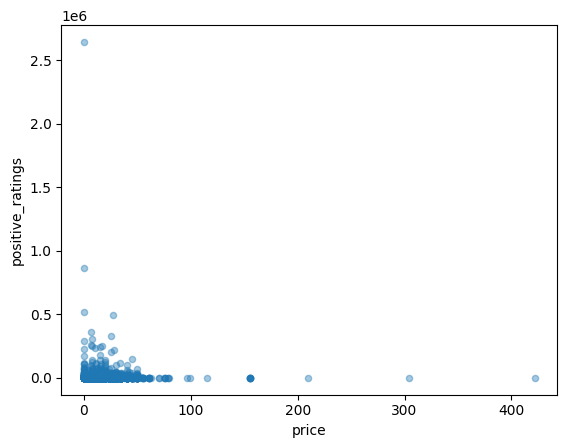

In [8]:
df.plot.scatter(x='price', y='positive_ratings', alpha=0.4)


<Axes: xlabel='average_playtime', ylabel='positive_ratings'>

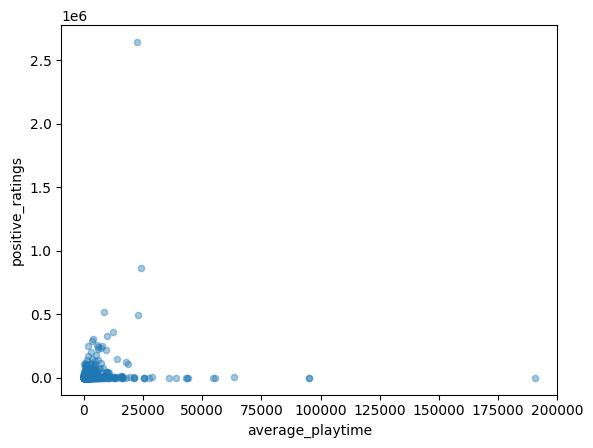

In [9]:
df.plot.scatter(x='average_playtime', y='positive_ratings', alpha=0.4)


## Genre and Tag Insights

In this section, we analyze:
- The most common genres and tags in the dataset.
- Average playtime and ratings by genre.
- How different tags may correlate with popularity or playtime.


In [10]:
from collections import Counter

tags = df["steamspy_tags"].dropna().str.split(";")
tag_counts = Counter(tag.strip() for sublist in tags for tag in sublist)
pd.DataFrame(tag_counts.most_common(10), columns=["Tag", "Count"])


,Tag,Count
0,Indie,16232
1,Action,10322
2,Casual,8205
3,Adventure,7770
4,Strategy,4173
5,Simulation,3284
6,Early Access,2967
7,RPG,2785
8,Free to Play,1662
9,Puzzle,1116


In [11]:
df['genre'] = df['genres'].str.split(';').str[0]  # Simplify
df.groupby('genre')['average_playtime'].mean().sort_values(ascending=False).head(10)


genre
Massively Multiplayer    3022.250000
Free to Play              663.202532
Racing                    347.071066
RPG                       316.535627
Photo Editing             293.000000
Simulation                261.649762
Strategy                  204.229323
Utilities                 166.633333
Adventure                 155.515601
Action                    149.868534
Name: average_playtime, dtype: float64

## Correlation Analysis

We use a heatmap to explore correlations between numeric features such as:
- Price
- Average playtime
- Positive and negative ratings
- Estimated number of owners

This helps us identify which variables move together and may be useful for prediction.


Text(0.5, 1.0, 'Correlation Between Key Metrics')

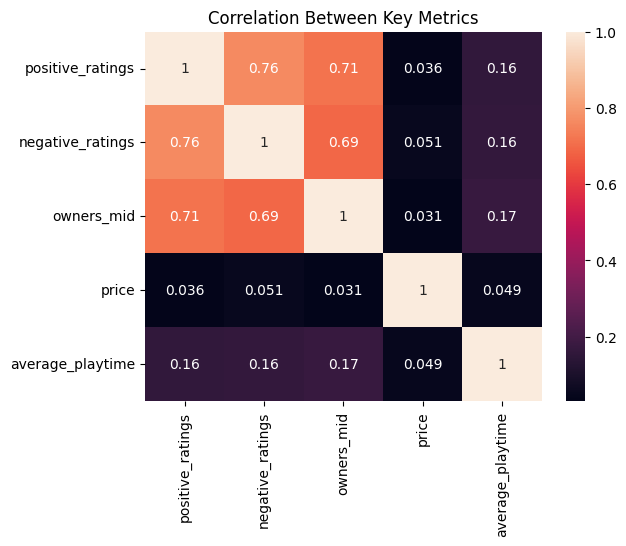

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df[['positive_ratings', 'negative_ratings', 'owners_mid', 'price', 'average_playtime']].corr(), annot=True)
plt.title("Correlation Between Key Metrics")


## Predicting Game Popularity with Machine Learning

In this section, we build a simple regression model to predict a game's estimated number of owners (`owners_mid`) based on available features.

**Features used:**
- `price`: Game's cost in USD
- `required_age`: Minimum age requirement
- `achievements`: Number of in-game achievements
- `average_playtime`: Average minutes played

We use a **Random Forest Regressor** from `sklearn` to fit and evaluate the model.


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

model_df = df[['price', 'required_age', 'achievements', 'average_playtime', 'owners_mid']].dropna()
X = model_df.drop('owners_mid', axis=1)
y = model_df['owners_mid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.6756987319749999

## Conclusion and Insights

### Key Takeaways:
- Positive ratings are more closely associated with playtime than price.
- Certain genres (e.g., RPG, Strategy) tend to have longer playtimes.
- Many of the most-owned games are older or free-to-play titles.

### Limitations:
- Owner counts are given as ranges and are approximations.
- Reviews do not capture sentiment, just counts.
- Game success may be influenced by external factors (e.g., marketing, IP recognition).

### Next Steps:
- Use machine learning to predict ownership or rating from features.
- Build an interactive dashboard to explore Steam data dynamically.
